#### **Import Libraries**

In [5]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp 
from tinygp import kernels
from tinygp import GaussianProcess
import numpy as np
import matplotlib.pyplot as plt

#### **Define Kernel**

In [2]:
def plot_kernel(kernel, **kwargs):
    dx = np.linspace(0, 5, 100)
    plt.plot(dx, kernel(dx, dx[:1]), **kwargs)
    plt.xlabel("dx")
    plt.ylabel("k(dx)")

2024-05-19 21:22:09.447183: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


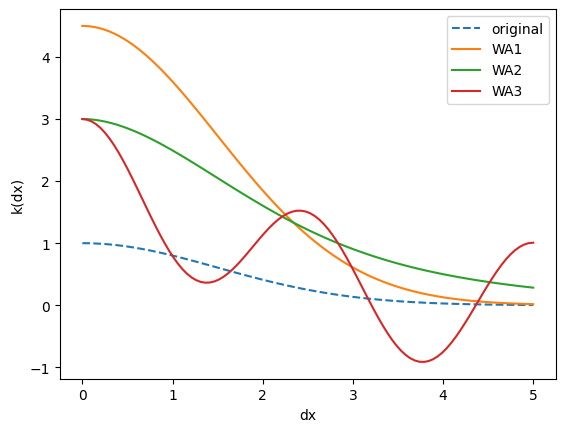

In [3]:
plot_kernel(kernels.ExpSquared(scale=1.5), label='original', linestyle='--')
plot_kernel(4.5*kernels.ExpSquared(1.5), label='WA1')
plot_kernel(kernels.ExpSquared(1.5) + 2 * kernels.Matern32(scale=2.5), label='WA2')
plot_kernel(2 * kernels.ExpSquared(1.5) + kernels.Cosine(scale=2.5), label='WA3')
_ = plt.legend()

In [13]:
def sample(kernel1, kernel2, n, key):
    k1, k2 = jax.random.split(key)
    xs = GaussianProcess(kernel1, jnp.arange(n), diag=1e-5).sample(k1)
    ys = GaussianProcess(kernel2, xs, diag=1e-5).sample(k2)
    return xs, ys

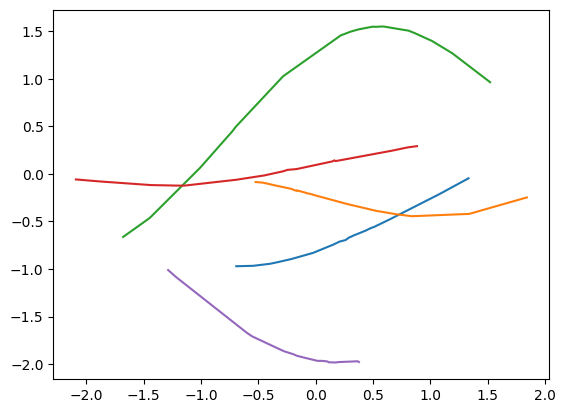

In [14]:
key = jax.random.PRNGKey(0)
for i in range(5):
    xs, ys = sample( kernels.Matern32(scale=2.5), kernels.ExpSquared(scale=1.5), 20, key)
    idx = jnp.argsort(xs)
    plt.plot(xs[idx], ys[idx])
    key, _ = jax.random.split(key)
plt.show()

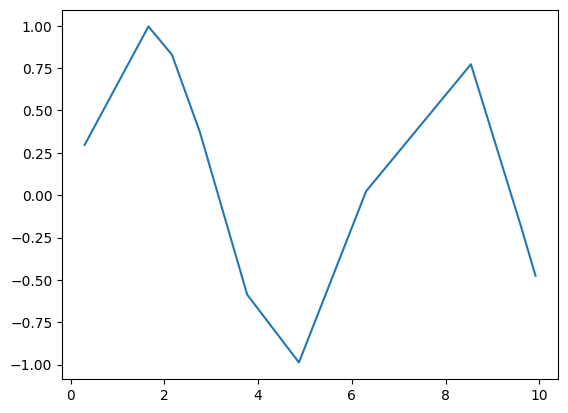

In [25]:
xs = jnp.sort(jax.random.uniform(jax.random.PRNGKey(0), maxval=10, shape=(10,)))
ys = np.sin(xs) + 1e-4 * jax.random.normal(jax.random.PRNGKey(1), shape=(10,))
plt.plot(xs, ys)
plt.show()

In [26]:
kernel = 0.5 * kernels.ExpSquared(scale=1.0)
gp = GaussianProcess(kernel, xs, diag=1e-4)
print(gp.log_probability(ys))

-4.650322861701913


In [30]:
def build_gp(params, xs):
    amp = jnp.exp(params['log_amp'])
    scale = jnp.exp(params['log_scale'])
    diag = jnp.exp(params['log_diag'])
    kernel = amp * kernels.ExpSquared(scale)
    return GaussianProcess(kernel, xs, diag)


@jax.jit 
def loss(params, xs, ys): 
    gp = build_gp(params, xs)
    return gp.log_probability(ys)

xs = jnp.linspace(0, 10, 10)

params = {'log_amp': -0.1, 
          'log_scale': 0.0, 
          'log_diag': -1.0}


In [27]:
X_test = np.linspace(0, 10, 100)
_, cond_gp = gp.condition(y, X_test)

# The GP object keeps track of its mean and variance, which we can use for
# plotting confidence intervals
mu = cond_gp.mean
std = np.sqrt(cond_gp.variance)
plt.plot(X_test, mu, "C1", label="mean")
plt.plot(X_test, mu + std, "--C1", label="1-sigma region")
plt.plot(X_test, mu - std, "--C1")

# We can also plot samples from the conditional
y_samp = cond_gp.sample(jax.random.PRNGKey(1), shape=(12,))
plt.plot(X_test, y_samp[0], "C0", lw=0.5, alpha=0.5, label="samples")
plt.plot(X_test, y_samp[1:].T, "C0", lw=0.5, alpha=0.5)

plt.plot(X, y, ".k", label="data")
plt.legend(fontsize=10)
plt.xlim(X_test.min(), X_test.max())
plt.xlabel("x")
_ = plt.ylabel("y")

ConditionResult(log_probability=Array(-4.65032286, dtype=float64), gp=GaussianProcess(
  num_data=10,
  dtype=dtype('float64'),
  kernel=Conditioned(
    X=f64[10],
    solver=DirectSolver(
      X=f64[10],
      variance_value=f64[10],
      covariance_value=f64[10,10],
      scale_tril=f64[10,10]
    ),
    kernel=Product(
      kernel1=Constant(value=0.5),
      kernel2=ExpSquared(scale=1.0, distance=L2Distance())
    )
  ),
  X=f64[10],
  mean_function=Conditioned(
    X=f64[10],
    alpha=f64[10],
    kernel=Product(
      kernel1=Constant(value=0.5),
      kernel2=ExpSquared(scale=1.0, distance=L2Distance())
    ),
    include_mean=True,
    mean_function=Mean(value=f64[], func=None)
  ),
  mean=f64[10],
  noise=Diagonal(diag=f64[10]),
  solver=DirectSolver(
    X=f64[10],
    variance_value=f64[10],
    covariance_value=f64[10,10],
    scale_tril=f64[10,10]
  )
))